In [2]:
import pandas as pd
import talib as ta
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans 

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import warnings
import logging
import platform
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)  # 设置 matplotlib 日志级别为 WARNING
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['Songti SC']
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['SimSun']
else:  # Linux
    plt.rcParams['font.family'] = ['Noto Sans CJK SC']
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

In [3]:
df = pd.read_csv('../data/stock.csv', parse_dates=True)

df.head()

,date,open,close,low,high,volume,count,amount
0,2017-10-26 12:00:00,230.00,296.67,230.00,299.40,148701.673027,52,575.1466
1,2017-10-26 12:30:00,296.28,290.00,290.00,296.68,164207.334934,48,557.3589
2,2017-10-26 13:00:00,291.43,292.69,289.01,294.00,448773.263215,49,1541.4099
3,2017-10-26 13:30:00,290.29,294.07,290.29,296.36,405905.625453,43,1379.0684
4,2017-10-26 14:00:00,293.65,292.30,292.00,293.65,317590.616442,43,1085.3961


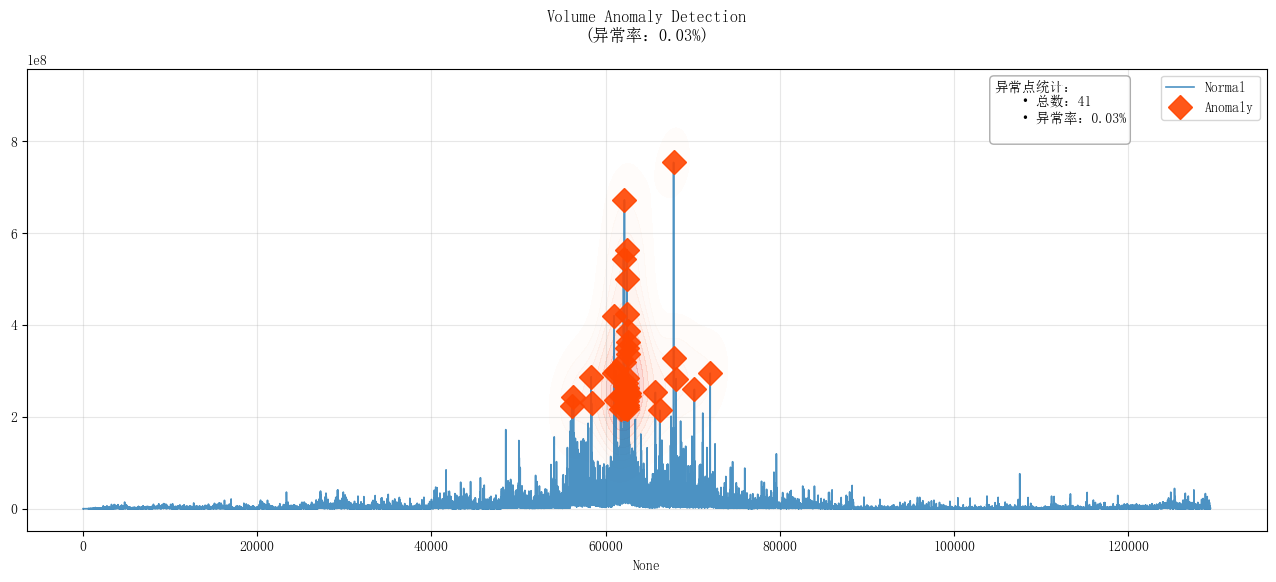

                      date     open    close      low     high        volume  \
56141  2021-01-08 02:30:00  1248.21  1223.13  1150.00  1256.23  2.238433e+08   
56303  2021-01-11 11:30:00  1109.20  1103.63  1009.00  1125.12  2.441779e+08   
58340  2021-02-22 22:00:00  1726.80  1670.65  1550.59  1744.16  2.872598e+08   
58378  2021-02-23 17:00:00  1446.19  1505.59  1351.10  1515.62  2.292517e+08   
60958  2021-04-18 11:00:00  2254.25  2125.76  2022.00  2269.01  2.946400e+08   
60959  2021-04-18 11:30:00  2126.18  2155.46  1940.00  2169.00  4.200095e+08   
61186  2021-04-23 05:00:00  2401.18  2415.57  2304.05  2429.37  2.369095e+08   
61196  2021-04-23 10:00:00  2322.01  2193.02  2116.00  2339.87  3.003995e+08   
61750  2021-05-04 23:00:00  3370.63  3303.35  3235.50  3394.71  2.461951e+08   
61752  2021-05-05 00:00:00  3228.95  3273.83  3162.64  3295.25  2.176384e+08   
62048  2021-05-11 04:00:00  3993.44  3907.64  3658.00  3993.44  5.444860e+08   
62148  2021-05-13 06:00:00  4124.76  409

In [4]:
def iso_forest_detect(series):
    model = IsolationForest(
        contamination=0.0005,  # 预期异常比例
        random_state=42
    )
    X = series.values.reshape(-1,1)
    return model.fit_predict(X) == -1
def plot_anomalies(series, anomalies, title):
    plt.figure(figsize=(16, 6))
    # 主序列
    ax = series.plot(label='Normal', alpha=0.8,linewidth=1.2)
    
    # 异常点（确保索引对齐）
    anomaly_points = series.loc[anomalies]
    anomaly_points.plot(
        ax=ax,
        style='D',
        markersize=12,
        color='#FF4500',  # 使用更醒目的橙色
        label='Anomaly',
        alpha=0.9
    )
    # 添加异常密度热力图
    if len(anomaly_points) > 0:
        sns.kdeplot(
            x=anomaly_points.index.astype(np.int64), 
            y=anomaly_points.values,
            cmap='Reds',
            fill=True,
            alpha=0.2,
            ax=ax
        )
    plt.title(f'{title} Anomaly Detection\n(异常率：{anomalies.mean():.2%})', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 添加统计信息框
    stats_text = f"""异常点统计：
    • 总数：{anomalies.sum()}
    • 异常率：{anomalies.mean():.2%}
    """
    
    plt.annotate(stats_text, 
                xy=(0.78, 0.85), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    plt.show()
iso_forest_anomalies = iso_forest_detect(df['volume'])

plot_anomalies(df['volume'], iso_forest_anomalies, 'Volume')

# df.loc[iso_forest_anomalies]=np.nan
# df.loc[iso_forest_anomalies] = df.loc[iso_forest_anomalies].ffill() # 使用线性插值填充异常值
print(df.loc[iso_forest_anomalies])

In [5]:
def create_features(data:pd.DataFrame):
    data['EMA20'] = ta.EMA(data['close'], timeperiod=20)
    data['EMA100'] = ta.EMA(data['close'], timeperiod=100)
    data['SMA20'] = ta.SMA(data['close'], timeperiod=20)
    data['SMA100'] = ta.SMA(data['close'], timeperiod=100)

    data['RSI'] = ta.RSI(data['close'], timeperiod=14)
    # 平均真实波幅
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=14)
    # 波动率
    data['Volatility'] = data['ATR'] / data['close']
    data['MACD'], data['Signal'], data['Hist'] = ta.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    # MACD线瞬时斜率
    data['macd_slope'] = data['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        data[f'macd_slope_ma{window}'] = data['macd_slope'].rolling(window).mean()
    
    # 计算价格波动率
    # 对数收益率滚动标准差
    data['close_volatility'] = np.log(data['close'] / data['close'].shift(1))
    data['Volatility_10'] = data['close_volatility'].rolling(window=10).std() * np.sqrt(10)
    data['close_Volume_volatility'] = data['close_volatility'] * data['volume']
    data['Volume_volatility_10'] = data['close_Volume_volatility'].rolling(window=10).std() * np.sqrt(10)
    # 计算布林带
    data['UpperBB'],data['MiddleBB'],data['LowerBB'] = ta.BBANDS(data['close'], timeperiod=20)

    # 特征工程
    for lag in [1, 3, 5]:
        data[f'return_lag{lag}'] = data['close'].pct_change(lag)
    # # 计算趋势线
    # seasonal_decompose = sm.tsa.seasonal_decompose(data['close'], model='additive', period=96) 
    # data['trend'] = seasonal_decompose.trend
    # data['seasonal'] = seasonal_decompose.seasonal
    # data['residual'] = seasonal_decompose.resid
    return df

def create_(data:pd.DataFrame):
    data[['final_peak', 'final_valley']].fillna(value=False)
    df['bottom_divergence'] = (df['final_valley'] == 1 & (df['macd_slope_ma3'] > 0)).astype(int)
    
    df['top_divergence'] = (df['final_peak'] == 1 & 
                                (df['macd_slope_ma3'] < 0)).astype(int)
    
    
    

In [6]:
df = create_features(df)

df.to_csv("../data/train.csv", index=False)

df.tail()

,date,open,close,low,high,volume,count,amount,EMA20,EMA100,...,close_volatility,Volatility_10,close_Volume_volatility,Volume_volatility_10,UpperBB,MiddleBB,LowerBB,return_lag1,return_lag3,return_lag5
129423,2025-03-14 19:30:00,1903.79,1902.16,1900.53,1906.27,4.236822e+05,309,222.580688,1892.458380,1890.802673,...,-0.000709,0.005840,-300.588856,3776.756933,1902.474385,1894.3625,1886.250615,-0.000709,0.002789,0.002408
129424,2025-03-14 20:00:00,1902.02,1903.02,1898.06,1908.00,6.834686e+05,613,359.078023,1893.464248,1891.044600,...,0.000452,0.005628,308.938360,3709.814233,1903.726314,1894.9825,1886.238686,0.000452,0.002988,0.004715
129425,2025-03-14 20:30:00,1904.20,1902.37,1894.74,1904.80,7.959735e+05,431,418.917436,1894.312415,1891.268865,...,-0.000342,0.005653,-271.921042,3693.204569,1904.699802,1895.4890,1886.278198,-0.000342,-0.000599,0.002900
129426,2025-03-14 21:00:00,1902.36,1898.69,1897.29,1905.17,7.555606e+05,401,397.377574,1894.729328,1891.415819,...,-0.001936,0.005442,-1462.993959,3128.699573,1904.486070,1896.0795,1887.672930,-0.001934,-0.001824,0.000706
129427,2025-03-14 21:30:00,1898.94,1908.77,1892.19,1911.97,1.198781e+06,807,629.826012,1896.066535,1891.759466,...,0.005295,0.007119,6347.404428,6848.409519,1906.512380,1897.0625,1887.612620,0.005309,0.003022,0.002763
